In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z_dim=128

In [3]:
class Autoencoder(nn.Module):
    def __init__(self,z_dim=128):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder =  nn.Sequential(
            nn.Conv2d(1,16, 3, stride=1, padding=1),   # 32x 28x 28]
            nn.ReLU(True),
            nn.Conv2d(16,32, 3, stride=2, padding=1),  # 64x 14x 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  #  64x 7x 7
            nn.ReLU(True),
        )
        # Latent space
        self.latent_space = nn.Linear(64 * 7 * 7, z_dim)
        # Decoder
        self.decoder_mlp= nn.Sequential(
            nn.Linear(z_dim, 64 * 7 * 7),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 7x7x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # 14x14x16
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1,3, stride=1, padding=1),  # 28x28x1
            nn.Sigmoid(),
        )
    def encoding(self,x):
        x = self.encoder(x)

        x = x.reshape(x.size(0), -1)  # flatten the tensor
        return self.latent_space(x)
    def decoding(self,x):
        x=self.decoder_mlp(x).view(x.size(0), 64, 7,7)
        x = self.decoder(x)  # reshape the tensor
        return x
    def forward(self, x):
        x = self.encoder(x)
       # print(x.shape)
        x = x.reshape(x.size(0), -1)  # flatten the tensor
        #print(x.shape)
        x = self.latent_space(x)
        #print(x.shape)
        x=self.decoder_mlp(x).view(x.size(0), 64, 7,7)
        #print(x.shape)
        x = self.decoder(x)  # reshape the tensor
        return x


In [4]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

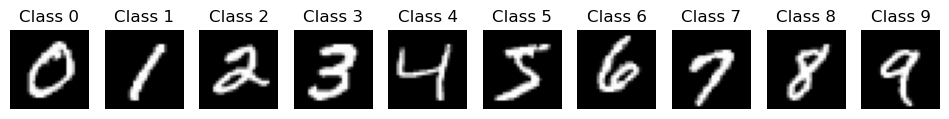

In [6]:
# Create a dictionary to store one sample for each class
samples = {}
for i in range(10):
    samples[i] = None
cpt=0
# Find the first occurrence of each class and store it in the dictionary
for data, target in train_dataset:
    if samples[target] is None:
        samples[target] = data
        cpt+=1
        if cpt==10:
            break

# Plot the samples
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(samples[i][0], cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.show()

In [7]:
# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torch import optim
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(z_dim).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [10]:
# Print Tensor Shape
# I=torch.rand((1,1,28,28)).cuda()
#with torch.no_grad():
# print(model(I).shape)

In [11]:

# Training
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()

        outputs = model(images.cuda())
        loss = nn.functional.binary_cross_entropy(outputs, images.cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    if epoch % 10==0:
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/100], Training Loss: 0.1631
Epoch [11/100], Training Loss: 0.0639
Epoch [21/100], Training Loss: 0.0623
Epoch [31/100], Training Loss: 0.0616
Epoch [41/100], Training Loss: 0.0611
Epoch [51/100], Training Loss: 0.0609
Epoch [61/100], Training Loss: 0.0607
Epoch [71/100], Training Loss: 0.0606
Epoch [81/100], Training Loss: 0.0605
Epoch [91/100], Training Loss: 0.0604


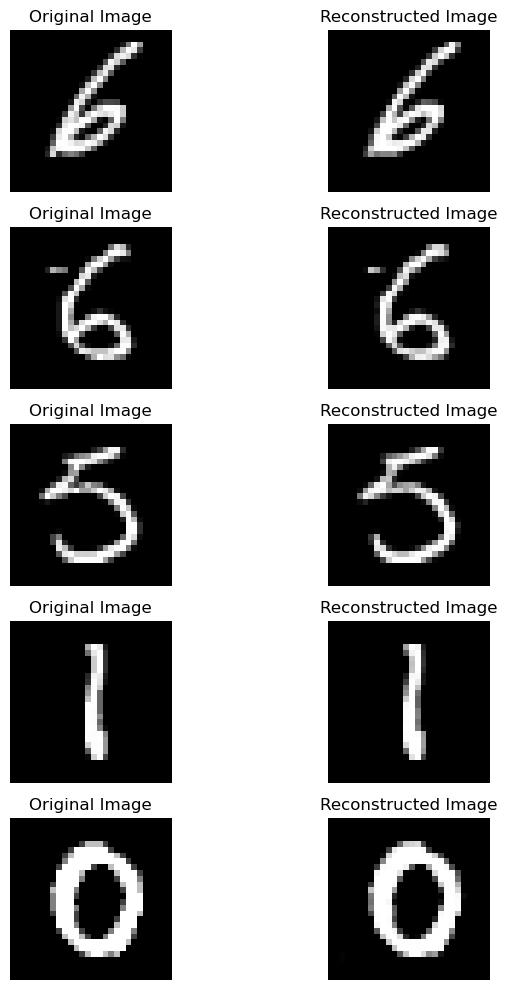

In [12]:
# Select random images from the test set and reconstruct them
num_images = 5
selected_indices = torch.randint(len(test_dataset), size=(num_images,))
reconstructed_images = []
original_images = []
for idx in selected_indices:
    image, _ = test_dataset[idx]
    original_images.append(image[0])
    with torch.no_grad():
        reconstructed_image = model(image.cuda().unsqueeze(0))
        reconstructed_images.append(reconstructed_image.squeeze().detach().cpu().numpy().reshape(28,28))

# Plot the original and reconstructed images
fig, axes = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axes[i, 0].imshow(original_images[i], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i], cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Scatter plot of latent space with respective class colors
latent_points = []
labels = []
with torch.no_grad():
    for images, targets in test_loader:
        latent= model.encoding(images.cuda())
        latent_points.extend(latent.detach().cpu().numpy())
        labels.extend(targets.numpy())

In [15]:
latent_points = np.array(latent_points)
labels = np.array(labels)


Text(0.5, 1.0, 't-SNE Visualization of Latent Space')

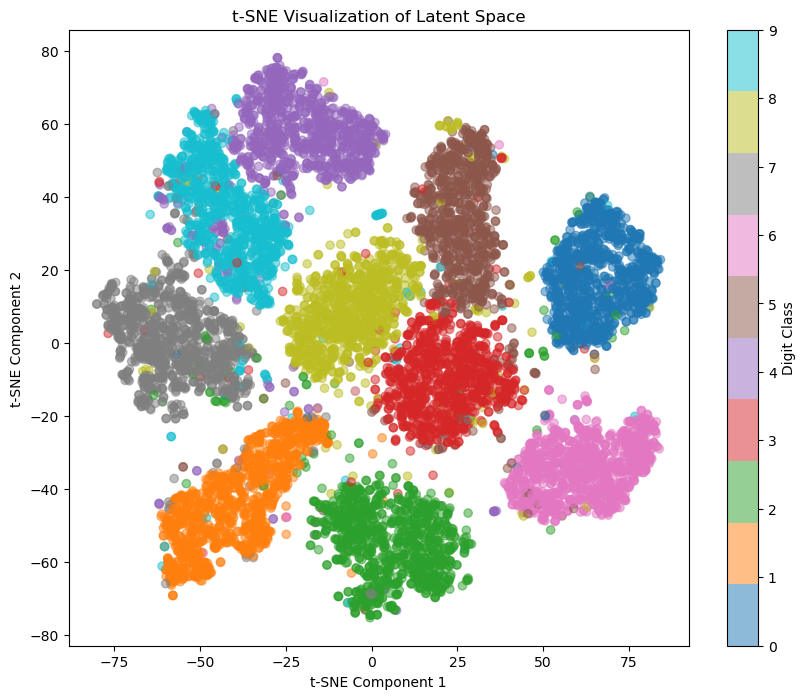

In [17]:
if z_dim>2:
  from sklearn.manifold import TSNE
  # Apply t-SNE to reduce the dimensionality of the latent representations to 2D
  tsne = TSNE(n_components=2, random_state=0)
  latent_2d = tsne.fit_transform(latent_points)
else:
  latent_2d = latent_points
# Plot the 2D latent representations
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets, cmap='tab10', alpha=0.5)
plt.colorbar(label='Digit Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space')


In [19]:
# Randomly select two latent points from the test set
selected_indices = np.random.choice(len(latent_points), 2, replace=False)
selected_latent = latent_points[selected_indices]
selected_latent_2d = latent_2d[selected_indices]
selected_labels = labels[selected_indices]

In [ ]:
# Plot latent space with class colors
plt.scatter(latent_2d[:, 0], latent_2d[:, 1],label='Latent Points')
plt.scatter(selected_latent_2d[:, 0], selected_latent_2d[:, 1], label='Selected Latent Points')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space with Selected Latent Points')
plt.legend()
plt.show()


In [ ]:
latent1, latent2 = torch.from_numpy(selected_latent)

# Interpolate between the two selected latent points
interpolation_points = torch.zeros((10, z_dim))
for i in range(10):
    interpolation_points[i] = latent1 + (latent2 - latent1) * i / 9

In [ ]:
# Decode the interpolated latent points
with torch.no_grad():
    decoded_images = model.decoding(interpolation_points.cuda()).detach().cpu().numpy().reshape(-1,28,28)



In [ ]:
# Plot the decoded images
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(decoded_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
# Select random image from the test set and reconstruct it

selected_indices = torch.randint(len(test_dataset), size=(1,)).item()

image, _ = test_dataset[selected_indices ]
with torch.no_grad():
        image_latent = model.encoding(image.cuda().unsqueeze(0))
        reconstructed_image=model.decoding(image_latent).squeeze().detach().cpu().numpy().reshape(28,28)
plt.subplot(121)
plt.imshow(image.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

In [ ]:
plt.hist(image_latent.detach().cpu().numpy().reshape(-1));
plt.title('Latent Histogram')

In [ ]:
modified_latent=image_latent.detach().cpu().numpy()
# Remove the K maxium values
K=30
sorted_idx=np.argsort(-modified_latent[0])
modified_latent[0,sorted_idx[:K]]=0

In [ ]:
with torch.no_grad():

        modified_latent_image=model.decoding(torch.from_numpy(modified_latent).float().cuda()).squeeze().detach().cpu().numpy().reshape(28,28)
plt.subplot(131)
plt.imshow(image.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(modified_latent_image, cmap='gray')
plt.title('Modified Latent')
plt.axis('off')

In [ ]:

selected_indices = torch.randint(len(test_dataset), size=(1,)).item()

imageB, _ = test_dataset[selected_indices]
with torch.no_grad():
        image_latentB = model.encoding(imageB.cuda().unsqueeze(0))
        reconstructed_imageB=model.decoding(image_latent+image_latentB).squeeze().detach().cpu().numpy().reshape(28,28)


plt.subplot(141)
plt.imshow(image.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Image A')
plt.axis('off')
plt.subplot(142)
plt.imshow(imageB.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Image B')
plt.axis('off')
plt.subplot(143)
plt.imshow(reconstructed_imageB, cmap='gray')
plt.title('Modified Latent')
plt.axis('off')
plt.subplot(144)
plt.imshow((image+imageB).detach().squeeze().cpu().numpy().clip(0,1), cmap='gray')
plt.title('A+B')
plt.axis('off')

In [ ]:

selected_indices = torch.randint(len(test_dataset), size=(1,)).item()

imageB, _ = test_dataset[selected_indices]
with torch.no_grad():
        image_latentB = model.encoding(imageB.cuda().unsqueeze(0))
        reconstructed_imageB=model.decoding(image_latent-image_latentB).squeeze().detach().cpu().numpy().reshape(28,28)


plt.subplot(141)
plt.imshow(image.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Image A')
plt.axis('off')
plt.subplot(142)
plt.imshow(imageB.detach().squeeze().cpu().numpy(), cmap='gray')
plt.title('Image B')
plt.axis('off')
plt.subplot(143)
plt.imshow(reconstructed_imageB, cmap='gray')
plt.title('Modified Latent')
plt.axis('off')
plt.subplot(144)
plt.imshow((image-imageB).detach().squeeze().cpu().numpy().clip(0,1), cmap='gray')
plt.title('A - B')
plt.axis('off')